In [51]:
import numpy as np
import symforce

symforce.set_backend("sympy")
symforce.set_log_level("warning")
from symforce.notebook_util import display, print_expression_tree

from symforce import sympy as sm
from symforce import geo
from symforce import typing as T
from symforce.opt.factor import Factor
from symforce.opt.optimizer import Optimizer
from symforce.values import Values

from symforce.opt.barrier_functions import (
    min_max_power_barrier,
    min_max_linear_barrier,
    max_linear_barrier
)

import numpy as np
import matplotlib.pyplot as plt

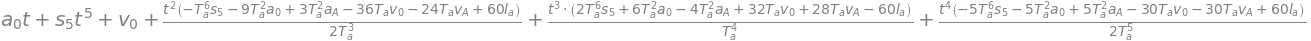

In [52]:
t = sm.Symbol("t")
T_a = sm.Symbol("T_a")
v_0 = sm.Symbol("v_0")
a_0 = sm.Symbol("a_0")
v_A = sm.Symbol("v_A")
a_A = sm.Symbol("a_A")
l_a = sm.Symbol("l_a")

polynomial_order = 5
coeffs = [sm.Symbol("s_{}".format(i)) for i in range(1, polynomial_order+1)]

def velocity_function(current_time):
    v_t = v_0
    for i in range(1, polynomial_order+1):
        v_t = v_t + coeffs[i-1] * current_time**i
    return v_t

def acc_function(current_time):
    tmp = sm.Symbol("tmp")
    return sm.diff(velocity_function(tmp), tmp).subs(tmp, current_time)

eq1 = sm.Eq(velocity_function(0), v_0)
eq2 = sm.Eq(velocity_function(T_a), v_A)
eq3 = sm.Eq(acc_function(0), a_0)
eq4 = sm.Eq(acc_function(T_a), a_A)
tmp = sm.Symbol("tmp")
eq5 = sm.Eq(sm.integrate(velocity_function(tmp), (tmp, 0, T_a)), l_a)

sol = sm.solve([eq1, eq2, eq3, eq4, eq5], coeffs[:4])

def sol_velocity_function_raw(current_time):
    return velocity_function(current_time).subs([(coeffs[0], sol[coeffs[0]]),
                                                 (coeffs[1], sol[coeffs[1]]),
                                                 (coeffs[2], sol[coeffs[2]]),
                                                 (coeffs[3], sol[coeffs[3]]),
                                                 ])

def sol_velocity_function(current_time, arrival_time, initial_v, initial_a, arrival_v, arrival_a, drive_length):
    return sol_velocity_function_raw(current_time).subs([
        (v_0, initial_v),
        (a_0, initial_a),
        (v_A, arrival_v),
        (a_A, arrival_a),
        (T_a, arrival_time),
        (l_a, drive_length)
    ])

sol_velocity_function_raw(t)

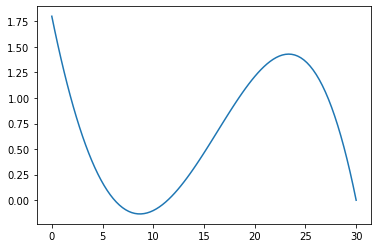

In [53]:
#initial_speed = 1.38
#initial_a = 0
#arrival_speed = 0
#arrival_a = -0.02
#drive_length = 30
#arrival_time = 20

initial_speed = 1.8
initial_a = -0.05 * 9.8
arrival_speed = 0
arrival_a = -0.05 * 9.8
drive_length = 20
arrival_time = 30

sol_velocity_function(t, arrival_time, initial_speed, initial_a, arrival_speed, arrival_a, drive_length)

opt_times = np.linspace(0, arrival_time, 100)
opt_v = [sol_velocity_function(ct, arrival_time, initial_speed, initial_a, arrival_speed, arrival_a, drive_length).subs(coeffs[4], 0) for ct in opt_times]

plt.plot(opt_times, opt_v)